# Run simulations

In [91]:
# Add project root to Python path
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Import necessary libraryes
import joblib
import numpy as np
import pandas as pd
import plotnine as p9
import psutil
from src.population_density_networks import model

## Modeling Parameters

In [120]:
# Simulation parameters
SIMULATION_ROUNDS = 100000
SIMULATION_REPLICATES = 25
N_JOBS = psutil.cpu_count(logical=True) - 1

# Fixed global parameters
N = 1000
K_CAP_MEAN = 1000
K_CAP_SD = 0
RADIUS = 10.0

# Varying parameters
DENSITIES = np.logspace(-3, 2, 11, base=10)


## Run Simulations

In [121]:
#####################
# Define simulation function
#####################
def run_single_simulation(density, replicate, n, k_cap_mean, k_cap_sd, radius, simulation_rounds):
    """Run a single simulation and return results as a dictionary."""
    # Initialize model
    model_run = model.NetworkFormationModel(
        n=n,
        k_cap_mean=k_cap_mean,
        k_cap_sd=k_cap_sd,
        radius=radius,
    )
    model_run.set_up_world(density=density)
    
    # Run simulation
    model_run.create_social_network(rounds=simulation_rounds, show_progress=False)
    
    # Analyze network structure
    network_structure = model.analyze_network_structure(model_run.social_network)
    
    # Create result dictionary
    result_dict = {
        'n': n,
        'k_cap_mean': k_cap_mean,
        'k_cap_sd': k_cap_sd,
        'radius': radius,
        'simulation_rounds': simulation_rounds,
        'population_density': np.round(density, 2),
        'replicate': replicate,
    }
    result_dict.update(network_structure.to_dict())
    return result_dict

    
#####################
# Run simulations
#####################
# Generate all parameter combinations
param_combinations = [
    (density, replicate, N, K_CAP_MEAN, K_CAP_SD, RADIUS, SIMULATION_ROUNDS)
    for density in DENSITIES
    for replicate in range(SIMULATION_REPLICATES)
]

print(f"🚀 Running {len(param_combinations)} simulations in parallel...")

# Run simulations in parallel
parallel_jobs = min(N_JOBS, len(param_combinations))
results_list = joblib.Parallel(n_jobs=parallel_jobs, verbose=10)(
    joblib.delayed(run_single_simulation)(*params) for params in param_combinations
)

# Convert results to DataFrame
results = pd.DataFrame(results_list)

🚀 Running 275 simulations in parallel...


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done   6 tasks      | elapsed:   49.9s
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done  35 tasks      | elapsed:  2.5min
[Parallel(n_jobs=13)]: Done  46 tasks      | elapsed:  3.3min
[Parallel(n_jobs=13)]: Done  59 tasks      | elapsed:  4.2min
[Parallel(n_jobs=13)]: Done  72 tasks      | elapsed:  5.0min
[Parallel(n_jobs=13)]: Done  87 tasks      | elapsed:  6.0min
[Parallel(n_jobs=13)]: Done 102 tasks      | elapsed:  6.9min
[Parallel(n_jobs=13)]: Done 119 tasks      | elapsed:  8.6min
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:  9.7min
[Parallel(n_jobs=13)]: Done 155 tasks      | elapsed: 11.2min
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed: 13.1min
[Parallel(n_jobs=13)]: Done 195 tasks      | elapsed: 14.8min
[Parallel(n_jobs=13)]: Done 216 tasks      | elapsed: 1

In [125]:
results

,n,k_cap_mean,k_cap_sd,radius,simulation_rounds,population_density,replicate,network_density,network_is_connected,network_num_components,network_largest_component_size,network_avg_shortest_path,network_diameter,network_clustering_coef,network_modularity,network_assortativity
0,1000,1000,0,10.0,100000,0.0,0,0.000310,False,856,5,1.600000,3,0.026000,0.987638,0.684425
1,1000,1000,0,10.0,100000,0.0,1,0.000308,False,856,5,1.600000,3,0.028000,0.988615,0.493572
2,1000,1000,0,10.0,100000,0.0,2,0.000334,False,845,5,1.700000,3,0.030667,0.988849,0.559227
3,1000,1000,0,10.0,100000,0.0,3,0.000294,False,861,4,1.666667,3,0.023333,0.989865,0.656783
4,1000,1000,0,10.0,100000,0.0,4,0.000332,False,845,4,1.666667,3,0.026333,0.988968,0.505163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,1000,1000,0,10.0,100000,100.0,20,0.200200,True,1,1000,1.799800,2,0.211823,0.044689,-0.014170
271,1000,1000,0,10.0,100000,100.0,21,0.200200,True,1,1000,1.799800,2,0.210441,0.044022,-0.008921
272,1000,1000,0,10.0,100000,100.0,22,0.200200,True,1,1000,1.799800,2,0.210083,0.044377,-0.008758
273,1000,1000,0,10.0,100000,100.0,23,0.200200,True,1,1000,1.799800,2,0.212026,0.044413,-0.013953


## Preliminary analysis of results
More in-depth plotting will be done in R.

In [126]:
#####################
# Calculate averages + simulation ranges for all network metrics
#####################
# Get all network metric columns (exclude boolean columns from quantile calculations)
network_metric_cols = [
    'network_density',
    'network_num_components', 'network_largest_component_size', 
    'network_avg_shortest_path', 'network_diameter',
    'network_clustering_coef', 'network_modularity',
    'network_assortativity'
]

# Define aggregation functions
def quantile_lower(x):
    return x.quantile(0.1)

def quantile_upper(x):
    return x.quantile(0.9)

# Create aggregation dictionary for all numeric network columns
agg_dict = {
    col: ['mean', 'std', quantile_lower, quantile_upper]
    for col in network_metric_cols
}

# Calculate statistics
summarized_stats = (
    results[['population_density'] + network_metric_cols]
    .groupby('population_density')
    .agg(agg_dict)
    .reset_index()
)

# Flatten multi-index columns
# The columns will be: population_density, then for each metric: mean, std, quantile_lower, quantile_upper
flat_cols = ['population_density']
for col in network_metric_cols:
    flat_cols.extend([f'{col}_mean', f'{col}_std', f'{col}_quantile_lower', f'{col}_quantile_upper'])
summarized_stats.columns = flat_cols

summarized_stats



,population_density,network_density_mean,network_density_std,network_density_quantile_lower,network_density_quantile_upper,network_num_components_mean,network_num_components_std,network_num_components_quantile_lower,network_num_components_quantile_upper,network_largest_component_size_mean,...,network_clustering_coef_quantile_lower,network_clustering_coef_quantile_upper,network_modularity_mean,network_modularity_std,network_modularity_quantile_lower,network_modularity_quantile_upper,network_assortativity_mean,network_assortativity_std,network_assortativity_quantile_lower,network_assortativity_quantile_upper
0,0.00,0.000647,0.000340,0.000302,0.001015,724.86,130.225395,584.8,859.0,7.58,...,0.018083,0.169683,0.990024,0.001570,0.987834,0.991886,0.570582,0.076964,0.481346,0.663107
1,0.01,0.003046,0.000077,0.002960,0.003119,145.68,11.964252,133.0,159.6,98.92,...,0.459868,0.500905,0.970799,0.002518,0.967799,0.973379,0.582055,0.035342,0.538035,0.622112
2,0.03,0.009450,0.000172,0.009274,0.009717,1.60,0.707107,1.0,2.6,998.76,...,0.596912,0.618492,0.787130,0.018949,0.761470,0.810615,0.591778,0.042989,0.542718,0.657469
3,0.10,0.028849,0.000446,0.028238,0.029398,1.00,0.000000,1.0,1.0,1000.00,...,0.614695,0.623491,0.604542,0.017433,0.583465,0.622803,0.591737,0.043793,0.538193,0.645465
4,0.32,0.084766,0.000965,0.083613,0.086309,1.00,0.000000,1.0,1.0,1000.00,...,0.642110,0.647133,0.464283,0.026755,0.429342,0.498369,0.556924,0.061893,0.489307,0.638516
5,1.00,0.196778,0.000882,0.196041,0.197711,1.00,0.000000,1.0,1.0,1000.00,...,0.589409,0.607372,0.358350,0.022282,0.340449,0.381061,0.214285,0.016769,0.191547,0.232413
6,3.16,0.200200,0.000000,0.200200,0.200200,1.00,0.000000,1.0,1.0,1000.00,...,0.286474,0.297820,0.181837,0.007870,0.173419,0.193510,-0.046800,0.005259,-0.053003,-0.041801
7,10.00,0.200200,0.000000,0.200200,0.200200,1.00,0.000000,1.0,1.0,1000.00,...,0.210813,0.211922,0.044678,0.000869,0.043529,0.045662,-0.014659,0.002873,-0.017821,-0.012513
8,31.62,0.200200,0.000000,0.200200,0.200200,1.00,0.000000,1.0,1.0,1000.00,...,0.210007,0.211428,0.044382,0.000913,0.043574,0.045414,-0.013110,0.002274,-0.015461,-0.010537
9,100.00,0.200200,0.000000,0.200200,0.200200,1.00,0.000000,1.0,1.0,1000.00,...,0.210427,0.211530,0.044532,0.001082,0.043181,0.045323,-0.012505,0.002098,-0.014669,-0.009702


/Users/christokita/side_projects/population-density-networks/.venv/lib/python3.14/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


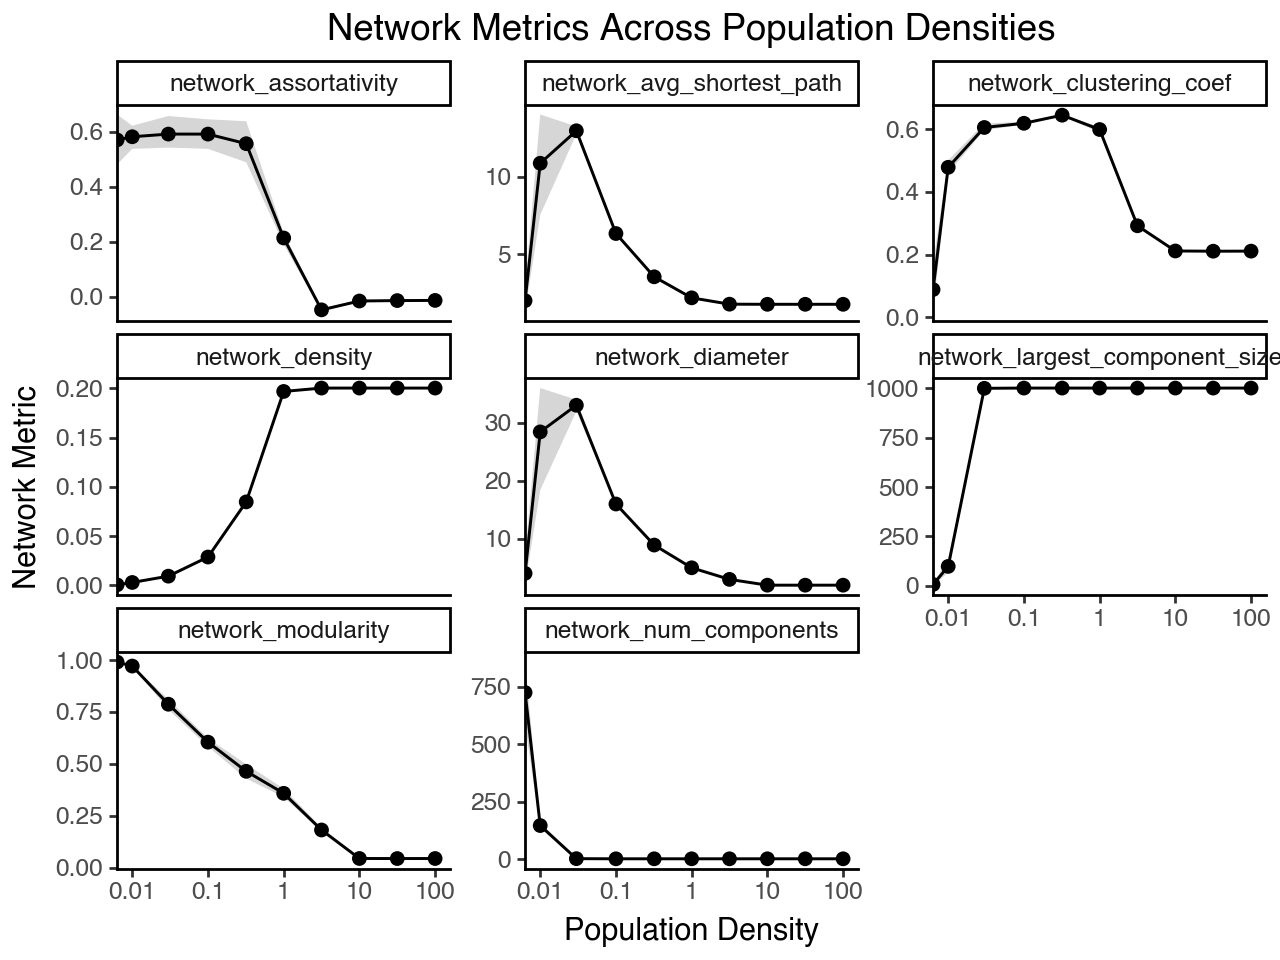

In [127]:
#####################
# Plot
#####################
from plotnine import (
    ggplot, aes, geom_point, geom_line, geom_ribbon, facet_wrap, labs, scale_x_continuous, theme_classic
)
import pandas as pd

# Melt summarized_stats for facetting
metrics_long = pd.melt(
    summarized_stats,
    id_vars=['population_density'],
    value_vars=[
        'network_density_mean', 'network_num_components_mean', 'network_largest_component_size_mean',
        'network_avg_shortest_path_mean', 'network_diameter_mean',
        'network_clustering_coef_mean', 'network_modularity_mean', 'network_assortativity_mean'
    ],
    var_name='metric', value_name='dummy'  # We will overwrite this, just a trick for index expansion
)

# Instead, we want: one row for each metric, with columns for mean, lower, upper
plot_df = pd.DataFrame()
for metric in [
        'network_density', 'network_num_components', 'network_largest_component_size',
        'network_avg_shortest_path', 'network_diameter',
        'network_clustering_coef', 'network_modularity', 'network_assortativity'
    ]:
    tmp = summarized_stats[['population_density',
                      f'{metric}_mean',
                      f'{metric}_quantile_lower',
                      f'{metric}_quantile_upper']].copy()
    tmp['metric'] = metric
    tmp = tmp.rename(columns={
        f'{metric}_mean': 'mean',
        f'{metric}_quantile_lower': 'lower',
        f'{metric}_quantile_upper': 'upper'
    })
    plot_df = pd.concat([plot_df, tmp], ignore_index=True)

# Plot
p = (
    ggplot(plot_df, aes(x='population_density', y='mean'))
    + geom_ribbon(aes(ymin='lower', ymax='upper'), alpha=0.2)
    + geom_line(size=0.6)
    + geom_point(stroke=0, size=3)
    + scale_x_continuous(trans='log10')
    + facet_wrap('~metric', scales='free_y')
    + labs(
        x='Population Density',
        y='Network Metric',
        title='Network Metrics Across Population Densities'
    )
    + theme_classic()
)
p
